In [28]:
from scipy.signal import fftconvolve, convolve2d
from astropy.io import fits
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 7]

# settings

In [2]:
simulation = "/home/gijs/Work/spiel/runs/second_kat7_2018-05-28/results/"
neural_output = "/home/gijs/Work/astro-pix2pix/scratch/spiel_test_kat7/fits/"
number = 401

# preface

In [3]:
!ls $simulation

0-settings.txt		   279-skymodel.fits	      459-skymodel.fits
0-skymodel.fits		   279-skymodel.txt	      459-skymodel.txt
0-skymodel.txt		   279-wsclean-dirty.fits     459-wsclean-dirty.fits
0-wsclean-dirty.fits	   279-wsclean-image.fits     459-wsclean-image.fits
0-wsclean-image.fits	   279-wsclean-model.fits     459-wsclean-model.fits
0-wsclean-model.fits	   279-wsclean-psf.fits       459-wsclean-psf.fits
0-wsclean-psf.fits	   279-wsclean-residual.fits  459-wsclean-residual.fits
0-wsclean-residual.fits    28-settings.txt	      46-settings.txt
1-settings.txt		   28-skymodel.fits	      46-skymodel.fits
1-skymodel.fits		   28-skymodel.txt	      46-skymodel.txt
1-skymodel.txt		   28-wsclean-dirty.fits      46-wsclean-dirty.fits
1-wsclean-dirty.fits	   28-wsclean-image.fits      46-wsclean-image.fits
1-wsclean-image.fits	   28-wsclean-model.fits      46-wsclean-model.fits
1-wsclean-model.fits	   28-wsclean-psf.fits	      46-wsclean-psf.fits
1-wsclean-psf.fits	   28-wsclean-residual.fits   

In [15]:

psf_path = "{}{}-wsclean-psf.fits".format(simulation, number)
outputs_path = "{}{}-outputs.fits".format(neural_output, number)
image_path = "{}{}-wsclean-image.fits".format(simulation, number)
skymodel_path = "{}{}-skymodel.fits".format(simulation, number)
dirty_path = "{}{}-wsclean-dirty.fits".format(simulation, number)
convolved_path = "{}{}-convoled.fits".format(simulation, number)
risidual_path = "{}{}-risidual.fits".format(simulation, number)

In [46]:
psf = fits.open(psf_path)[0].data.squeeze()
output = fits.open(outputs_path)[0].data.squeeze()    # the output of the neural network
skymodel = fits.open(skymodel_path)[0].data.squeeze() # the skymodel used as input to the telescope sim pipeline
dirty = fits.open(dirty_path)[0].data.squeeze()       # dirty image created by wsclean
image = fits.open(image_path)[0].data.squeeze()       # cleaned image created by wsclean

In [47]:
threshold = np.mean(output) + np.std(output) * 1
print("threshold: {}".format(threshold))

threshold: 0.012122106418246403


# PSF

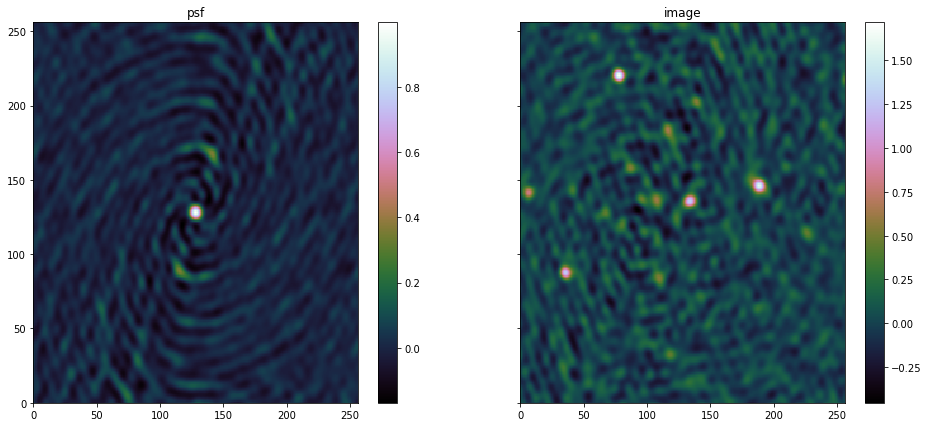

In [51]:
f, (a1, a2) = plt.subplots(1, 2, sharey=True)
i1 = a1.pcolor(psf, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('psf')
i2 = a2.pcolor(image, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('image')

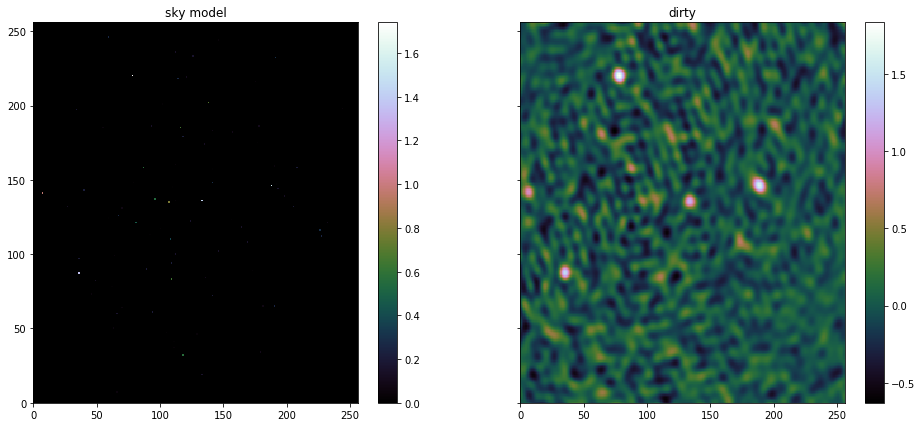

In [50]:
f, (a1, a2) = plt.subplots(1, 2, sharey=True)
i1 = a1.pcolor(skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('sky model')
i2 = a2.pcolor(dirty, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('dirty')

# thresholding
The scales of the network are still wrong, so we do thresholding and scaling

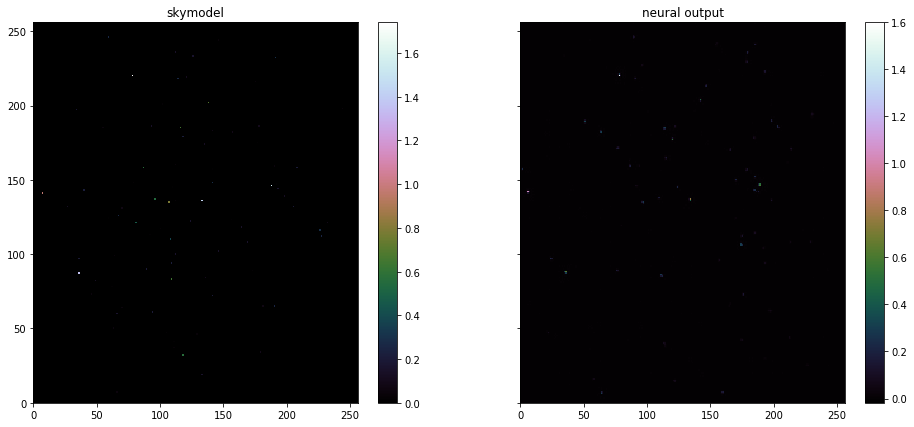

In [59]:
f, (a1, a2) = plt.subplots(1, 2, sharey=True)
i1 = a1.pcolor(skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('skymodel')
i2 = a2.pcolor(output, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('neural output')

In [64]:
thresholded = output * (output > threshold)
scaled = thresholded # * (skymodel.max()/thresholded.max()) 

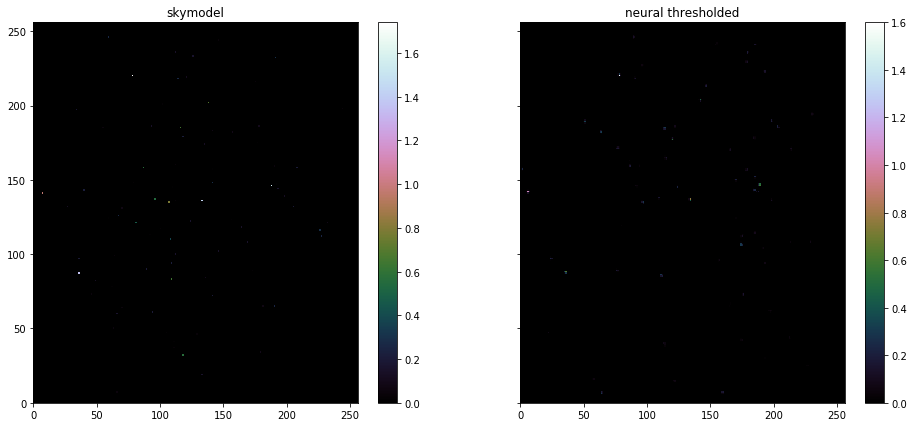

In [65]:
f, (a1, a2) = plt.subplots(1, 2, sharey=True)
i1 = a1.pcolor(skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('skymodel')
i2 = a2.pcolor(thresholded, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('neural thresholded')

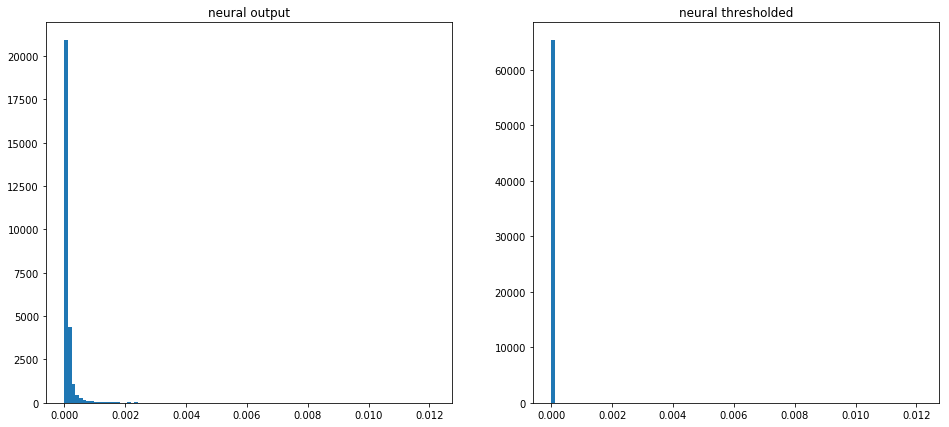

In [66]:
f, (a1, a2) = plt.subplots(1, 2)
a1.hist(output.flatten(), range=(0, threshold), bins=100)
a1.set_title('neural output')
a2.hist(thresholded.flatten(), range=(0, threshold), bins=100)
_ = a2.set_title('neural thresholded')

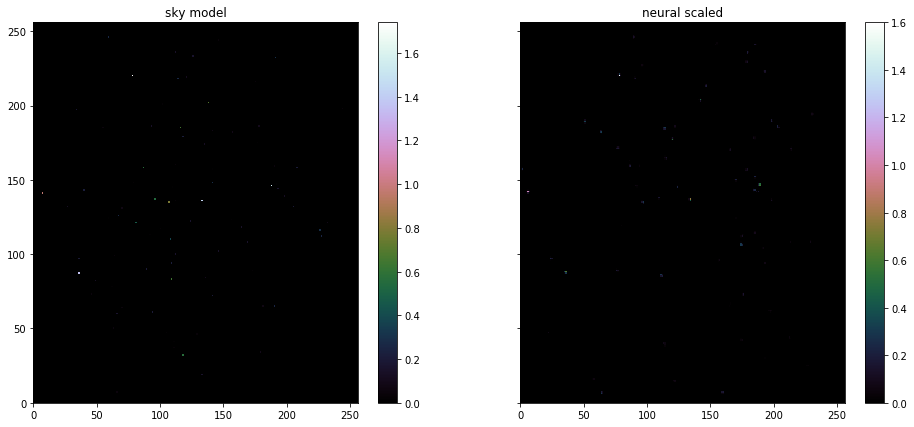

In [67]:
f, (a1, a2) = plt.subplots(1, 2, sharey=True)
i1 = a1.pcolor(skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('sky model')
i2 = a2.pcolor(scaled, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('neural scaled')

# Convolving

In [73]:
convolved_skymodel = fftconvolve(skymodel, psf, mode="same")
convolved_neural = fftconvolve(scaled, psf, mode="same")

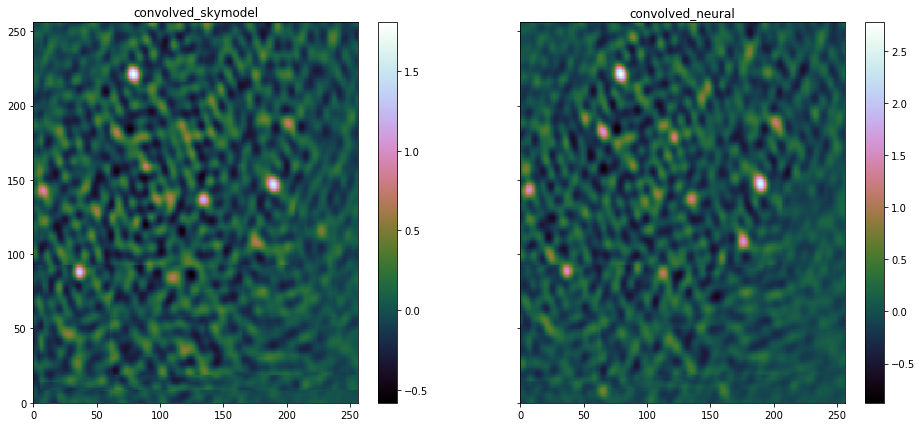

In [69]:
f, (a1, a2) = plt.subplots(1, 2, sharey=True)
i1 = a1.pcolor(convolved_skymodel, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('convolved_skymodel')
i2 = a2.pcolor(convolved_neural, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('convolved_neural')

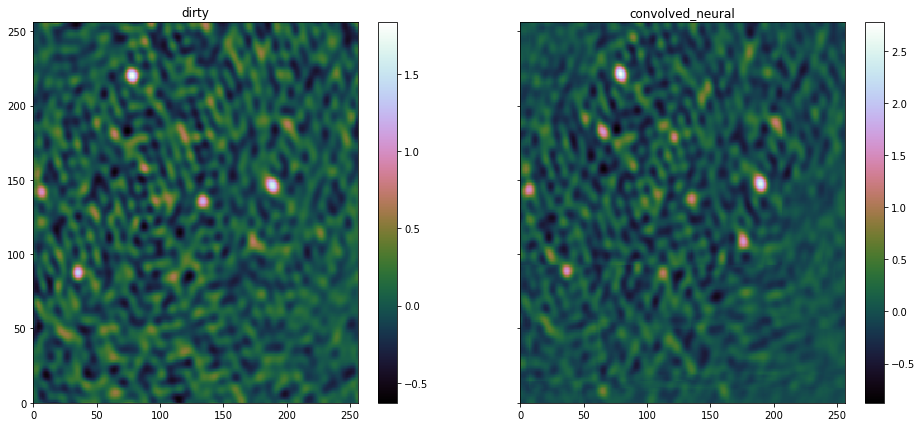

In [74]:
f, (a1, a2) = plt.subplots(1, 2, sharey=True)
i1 = a1.pcolor(dirty, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('dirty')
i2 = a2.pcolor(convolved_neural, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('convolved_neural')

# Risidual

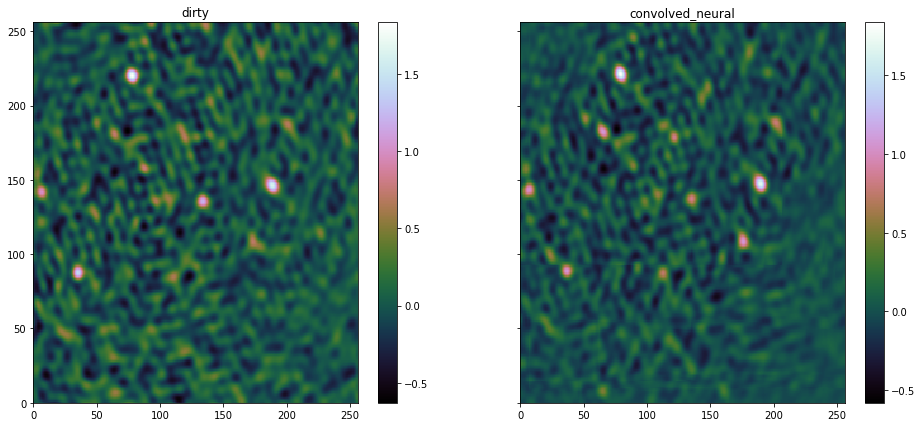

In [76]:
# scale convoled to dirty image
convolved_neural = convolved_neural * (dirty.max() / convolved_neural.max())
f, (a1, a2) = plt.subplots(1, 2, sharey=True)
i1 = a1.pcolor(dirty, cmap='cubehelix')
f.colorbar(i1, ax=a1)
a1.set_title('dirty')
i2 = a2.pcolor(convolved_neural, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('convolved_neural')

In [71]:
risidual_neural = dirty - convoled_neural
risidual_skymodel = dirty - convoled_skymodel

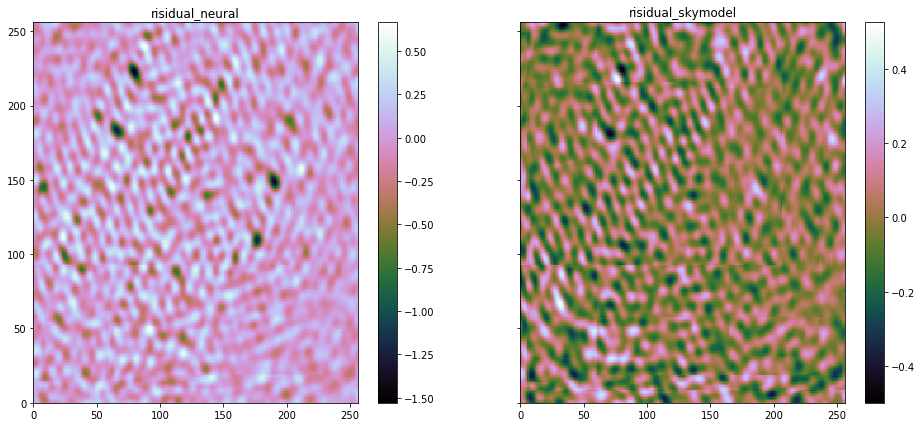

In [77]:
f, (a1, a2) = plt.subplots(1, 2, sharey=True)
i1 = a1.pcolor(risidual_neural, cmap='cubehelix')
a1.set_title('risidual_neural')
f.colorbar(i1, ax=a1)
i2 = a2.pcolor(risidual_skymodel, cmap='cubehelix')
f.colorbar(i2, ax=a2)
_ = a2.set_title('risidual_skymodel')

In [ ]:
f, (a1, a2) = plt.subplots(1, 2, sharey=True)
a1.pcolor(dirty, cmap='cubehelix')
a1.set_title('dirty')
a2.pcolor(risidual, cmap='cubehelix')
_ = a2.set_title('risidual skymodel')

In [ ]:
# write risidual
hdu = fits.PrimaryHDU(risidual)
hdu.header = dirty = fits.open(dirty_path)[0].header
hdul = fits.HDUList([hdu])
hdul.writeto(risidual_path, overwrite=True)

In [ ]:
# write convolved
hdu = fits.PrimaryHDU(risidual)
hdu.header = dirty = fits.open(dirty_path)[0].header
hdul = fits.HDUList([hdu])
hdul.writeto(risidual_path, overwrite=True)